# Final: saving all HMM data, of which the states timecourses.

## The libraries and methods we need:

In [26]:
import numpy as np
from loader import load_oneIC

In [27]:
from sklearn.decomposition import PCA
from hmmlearn import hmm
import scipy.signal as signal
import pickle

In [28]:
import matplotlib.pyplot as plt

In [29]:
import h5py

In [30]:
import xarray as xr

In [31]:
directory = "E:/timot/Documents/1 - Centrale Marseille/0.5 - Semestre S8/Stage/NIC_250819"
file = "FCK_LOCKED_IC_JYOTIKA_250819.mat"

path = f"{directory}/{file}"

mat_file = h5py.File(path, "r")
cells_refs = mat_file['FCK_LOCKED_IC_JYOTIKA']

n_IC = 4
n_subj = 23

## Functions:

### Plotting and saving functions:

In [32]:
def show_bigstates(
    gamma, n_states, # the data we need for the plot
    
    subj, IC, # which IC of which subject is of interest here
    
    n_components, n_lags, covariance_type, model_type, n_mix, # infos we put in the .png name if we want to save it
    
    save=False # do we really want to save the figure?
):

    fig = plt.figure(figsize=(6, 6))
    plt.title('State Power Spectrum')
    max_power = np.zeros(n_states)
    max_freq = np.zeros(n_states)
    for i in range(n_states):

        # Compute PSD separately for each lag
        tot = []
        for seg in xe[0, gamma[:, i]> .6, :].T:
            freqs, psd = signal.welch(x=seg, fs=256, nfft=1000)
            tot.append(psd)
        psd = np.mean(np.asarray(tot), 0)
        
        max_freq[i] = freqs[np.argmax(psd[50:])]
        max_power[i] = np.amax(psd[50:])

        plt.plot(freqs, psd)
        
    '''
    Ici il va falloir enregistrer freqs[:50Hz], psd[:50Hz] for i in range n_states dans un fichier json ou pickle
    Enregistrer ces petits plots c'est quand même utile pour mieux visualiser la cohérence de nos données
    '''
    
    plt.xlim(0, 50)
    plt.ylabel('PSD')
    plt.xlabel('Frequencies (Hz)')
    plt.legend([f'state {i+1}' for i in range(n_states)], loc='upper right')
    plt.tight_layout()   

    if save==True:
        plt.savefig(f'tde-hmm2/su{subj}IC{IC}All_lg{n_lags}co{n_components}st{n_states}'
                    +f'{n_mix}'+model_type+'_states-info.png', dpi=600)
    
    plt.close(fig)
    
    return max_freq, max_power
    

In [57]:
def plot_hmm_over_bigtfr(   
    bigtime, bigtfr, gamma, lags, n_states, max_power, # the data we need for the plot
    
    subj, IC, # which IC of which subject is of interest here
    
    n_components, n_lags, covariance_type, model_type, n_mix, # infos we put in the .png name if we want to save it
    
    save=False # do we really want to save the figure?
):
    print("test")
    fig = plt.figure(figsize=(16*3, 5))

    # HMM states probability plot
    plt.subplot(211)
    plt.title('HMM States probability')
    time = bigtime[np.abs(np.min(lags)):-np.abs(np.max(lags))]

    burst = np.argmax(max_power) # this is the burst state index
    
    labels = ['']
    states = np.where([i not in [burst] for i in range(n_states)])[0] # the other indexes
    for i in states:
        plt.fill_between(x=time[:1793*3-60], y1=gamma[:1793*3-60, i], alpha=0.2)
        plt.xlim(0, 7*3)
        labels.append(f'state {i+1}')
    plt.plot(time[:1793*3-60], gamma[:1793*3-60, burst]>0.6, 'red')
    labels[0]=(f'burst state (state {burst+1})')
    plt.fill_between(x=time[:1793*3-60], y1=gamma[:1793*3-60, burst], alpha=0.2, color='red')
    plt.ylabel('State probability')
    plt.legend(labels, loc='upper left')
    
    '''
    Ici il va falloir enregistrer `gamma>0.6` dans un fichier json ou pickle
    Pourquoi ne pas écrire quelques lignes directement en dehors de la fonction ?
    Enregistrer ces petits plots c'est quand même utile pour mieux visualiser la cohérence de nos données
    '''

    # Time-frequency plot
    plt.subplot(212)

    plt.title('Wavelet transform')
    plt.imshow(bigtfr[0, :, :1793*3], vmax=5,
               aspect='auto', origin='lower', extent=[0, 7*3, 2, 50], cmap='seismic')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequencies (Hz)')
    plt.tight_layout()
    
    if save == True:
        plt.savefig(f'tde-hmm2/su{subj}IC{IC}All_lg{n_lags}co{n_components}st{n_states}'
                    +f'{n_mix}'+model_type+'_hmm-tfr.png', dpi=600)
        
#     plt.close(fig)

## The routine:

We want to access the data in our .nc files and then use analyse them to have plots etc.

For example, we could want to :
- Plot the states timecourse over a tfr
- Plot the statewise PSD
- Plot the statewise coherence and PDC
- Plot the fractional occupancy of states (over a tfr)
- 

In [34]:
# The parameters we change to hope for some results
lags = np.arange(-29, 29)
n_lags = lags.shape[0]
n_iter=100
n_states=3    # for the Hidden Markov Model
n_components=40     # For the principal component analysis
covariance_type='diag'
model_type='GMMHMM'
tol=0.01
n_mix=1

In [35]:
ds_disk = xr.open_dataset("tde-hmm2/19.06 nc_files/su2IC1-states_psd.nc")

In [36]:
ds_disk["states_psd"].values

array([[0.00674906, 0.01574792, 0.02155415, 0.02863383, 0.03460431,
        0.03806266, 0.03889307, 0.03783982, 0.03584438, 0.03361079,
        0.03151892, 0.02972917, 0.02829315, 0.02720278, 0.02640289,
        0.02580112, 0.02528429, 0.02473942, 0.02407863, 0.02326134,
        0.02230051, 0.02124573, 0.02015357, 0.01906575, 0.01800778,
        0.01700165, 0.01607509, 0.01525576, 0.01455501, 0.01395775,
        0.01343066, 0.01294514, 0.01249811, 0.01211438, 0.01182898,
        0.01166228, 0.01160465, 0.01161721, 0.01164333, 0.01162081,
        0.01149007, 0.01120151, 0.01072619, 0.01006836, 0.00927119,
        0.00840837, 0.00756227, 0.00679881, 0.00615162, 0.00562197,
        0.00519161, 0.00483881, 0.00454809, 0.0043104 , 0.00411774,
        0.00395909, 0.00382167, 0.00369571, 0.00357789, 0.00347046,
        0.00337775, 0.00330329, 0.00324906, 0.00321528, 0.00319913,
        0.0031935 , 0.00318857, 0.00317653, 0.00315648, 0.00313495,
        0.00312146, 0.00312244, 0.00313834, 0.00

In [37]:
test = np.arange(0, 50, 50/196)
test

array([ 0.        ,  0.25510204,  0.51020408,  0.76530612,  1.02040816,
        1.2755102 ,  1.53061224,  1.78571429,  2.04081633,  2.29591837,
        2.55102041,  2.80612245,  3.06122449,  3.31632653,  3.57142857,
        3.82653061,  4.08163265,  4.33673469,  4.59183673,  4.84693878,
        5.10204082,  5.35714286,  5.6122449 ,  5.86734694,  6.12244898,
        6.37755102,  6.63265306,  6.8877551 ,  7.14285714,  7.39795918,
        7.65306122,  7.90816327,  8.16326531,  8.41836735,  8.67346939,
        8.92857143,  9.18367347,  9.43877551,  9.69387755,  9.94897959,
       10.20408163, 10.45918367, 10.71428571, 10.96938776, 11.2244898 ,
       11.47959184, 11.73469388, 11.98979592, 12.24489796, 12.5       ,
       12.75510204, 13.01020408, 13.26530612, 13.52040816, 13.7755102 ,
       14.03061224, 14.28571429, 14.54081633, 14.79591837, 15.05102041,
       15.30612245, 15.56122449, 15.81632653, 16.07142857, 16.32653061,
       16.58163265, 16.83673469, 17.09183673, 17.34693878, 17.60

---- SUBJECT2, IC1 ----
Loading the raw timecourse
Computing and loading the time-frequency wavelet transformation for 3 trials
test2
test
subj2, IC1: OK


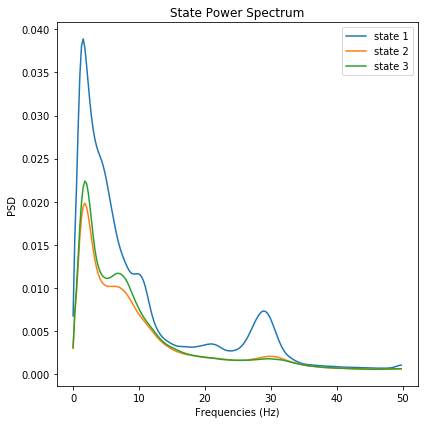

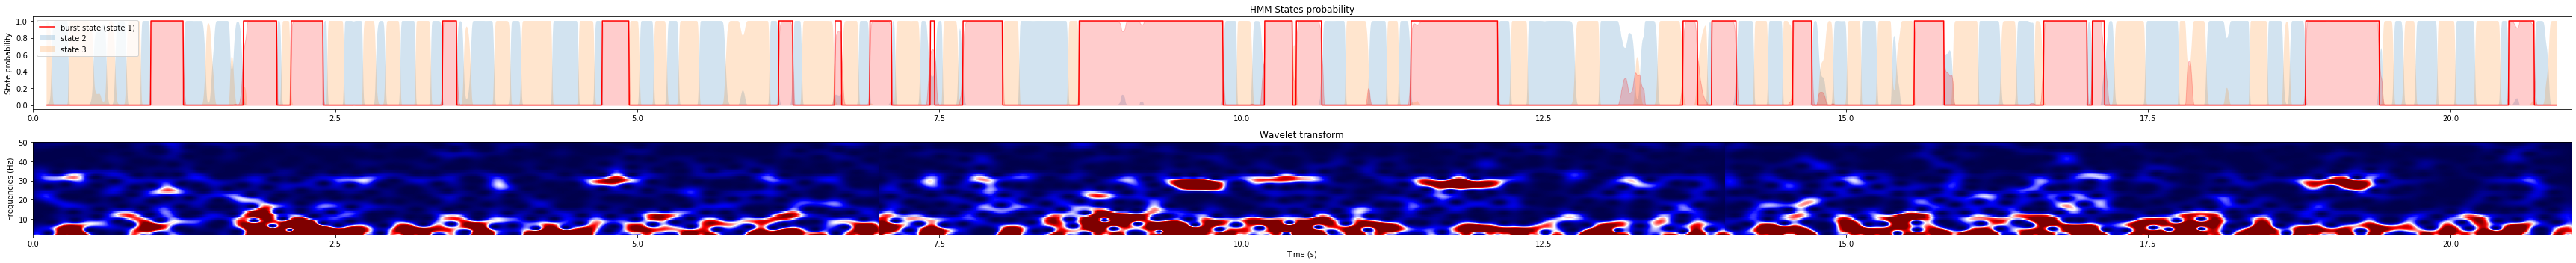

In [58]:
subj_list = [i for i in range(2,9)] + [i for i in range(10,13)] + [14] + [i for i in range(16, n_subj+1)] 
                                                                            # All except subjects 1, 9, 13, 15
# for subj in subj_list:  
#     for IC in range(1, n_IC+1): 
for subj in [2]:
    for IC in [1]:
        try:
            print(f"---- SUBJECT{subj}, IC{IC} ----")
            # Loading all data for subject{subj}, IC{IC}
            data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC)
            
            # Finding and saving the model
            big_timecourse = np.concatenate([data[f'raw_timecourse_256Hz'][i] for i in range(n_trials)])
            x = big_timecourse.reshape(-1, 1)
            
            gammadata = xr.open_dataset(f"tde-hmm2/19.06 nc_files/su{subj}IC{IC}-states_timecourse_256Hz.nc")
            gamma = gammadata["states_timecourse_256Hz"].values
            
            psddata = xr.open_dataset(f"tde-hmm2/19.06 nc_files/su{subj}IC{IC}-states_psd.nc")
            psd = psddata["states_psd"].values
            
            # Saving the Power Spectral Density of each state
            fig = plt.figure(figsize=(6, 6))
            plt.title('State Power Spectrum')
            max_power = np.zeros(n_states)
            max_freq = np.zeros(n_states)
            freqs = np.arange(0, 50, 50/196)
            for i in range(n_states):
                max_power[i] = np.amax(psd[i, 80:])
                plt.plot(freqs, psd[i])
            plt.ylabel('PSD')
            plt.xlabel('Frequencies (Hz)')
            plt.legend([f'state {i+1}' for i in range(n_states)], loc='upper right')
            plt.tight_layout()
            
            # Saving probability timecourses of the states over the tfr 
            time = data['time_axis']
            bigtime = np.concatenate([time+4+(7*i) for i in range(3)])
            bigtfr = np.concatenate([data[f'tfr_256Hz trial{i+1}'] for i in range(3)], axis=2)
            
            print("test2")
            
            plot_hmm_over_bigtfr(   
                bigtime, bigtfr, gamma, lags, n_states, max_power, # the data we need for the plot
                subj, IC, # which IC of which subject is of interest here, how many trials
                n_components, n_lags, covariance_type, model_type, n_mix, # infos we put in the .png name if we want to save it
                save=False # do we really want to save the figure?
            )
            print(f"subj{subj}, IC{IC}: OK")
        except:
            print(f"subj{subj}, IC{IC}: NOT POSSIBLE")

test


ValueError: operands could not be broadcast together with shapes (5322,) (5331,) 

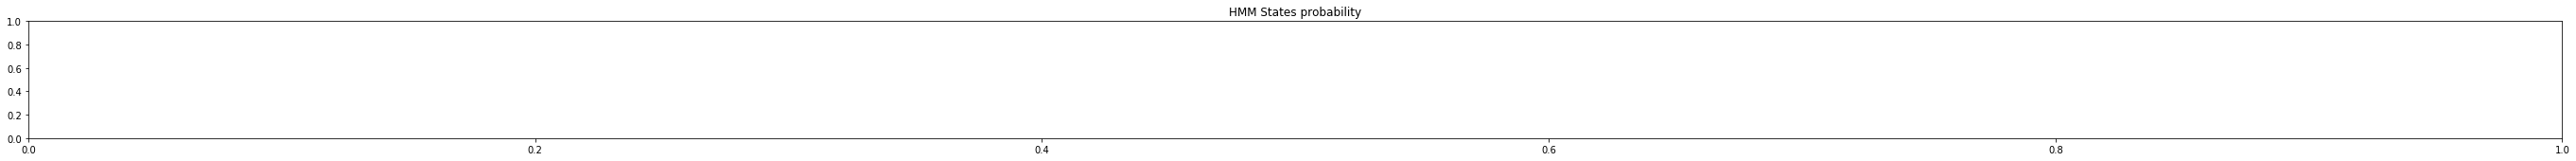

In [47]:
plot_hmm_over_bigtfr(   
    bigtime, bigtfr, gamma, lags, n_states, max_power, # the data we need for the plot
    subj, IC, # which IC of which subject is of interest here, how many trials
    n_components, n_lags, covariance_type, model_type, n_mix, # infos we put in the .png name if we want to save it
    save=False # do we really want to save the figure?
)